# Coursework E 
SN: 21019919

## Introduction

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.


PLEASE NOTE ALL CELLS WILL RUN, SOME TAKE LONGER THAN OTHERS.

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style 
import matplotlib as mpl 

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy import linalg


## Ryan's Functions

In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

## Functions for use in code

In [3]:
def sols_normal(tmax, z0, t, L1, L2, m1, m2):
    """
    Finds the solutions to a double pendulum's differential equations, via integration.

    Inputs:
        tmax: Total time to run integration.
        z0:   Pendulum's initial conditions.
        t:    Time points where the solution is to be evaluated.
        L1:   First pendulum arm length.
        L2:   Second pendulum arm length.
        m1:   First pendulum mass.
        m2:   Second pendulum mass.

    Outputs:
        x1: Pendulum 1 x-position
        y1: Pendulum 1 y-position 
        x2: Pendulum 2 x-position 
        y2: Pendulum 2 y-position
    
    """
    
    # Earth's gravatational constant
    g = 9.81
    
    #solve the initial value problem for the differential equations
    ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g)).y

    # extract the solutions for angles and angular velocities
    theta1, w1, theta2, w2 = ret[0], ret[1], ret[2], ret[3]
    
    # convert polar coordinates to Cartesian coordinates using predefined to_cartesian function
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
     
    return x1, y1, x2, y2

## Initial parameters

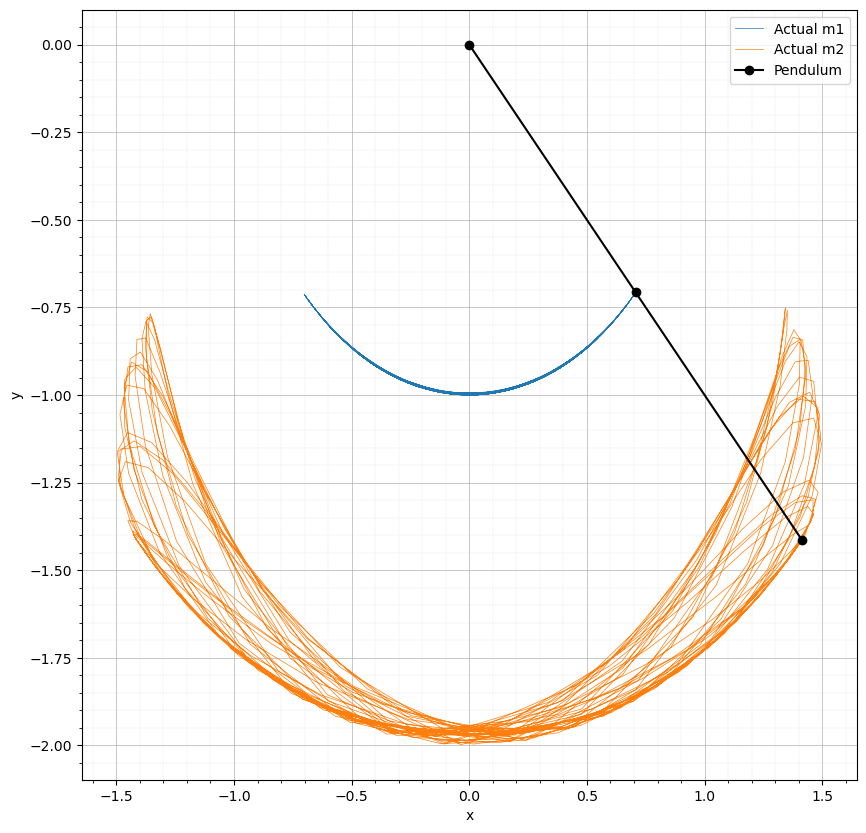

In [4]:
#lengths, masses and gravity constant
L1, L2 = 1.0, 1.0
m1, m2 = 3.0, 1.0
g = 9.81     

#starting position
z0=[np.pi/4,0,np.pi/4,0]

#time steps and max time
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)


#solving for initial conditions
x1, y1, x2, y2 = sols_normal(tmax, z0, t, L1,L2,m1,m2)

#plotting solutions
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(x1, y1,"-", label="Actual m1", linewidth=0.5)
ax.plot(x2, y2,"-", label="Actual m2", linewidth=0.5)
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Pendulum", c='k')
plt.ylabel("y")
plt.xlabel("x")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
ax.legend()
plt.show()

## Graph Inferences:
This is pretty much the plot that Ryan made so it looks nice, I added some features myself to make it clearer.

## Defining our model

In [5]:
model=keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model.compile(loss='mean_squared_error', optimizer='adam')

## Definfing Training and Testing splits

In [6]:
# 70/30 split array is used as according to Gholamy et al [1] this will achieve the best results.

high = int(0.7*len(y1))
data_test=np.column_stack((x1[high:-1], y1[high:-1],x2[high:-1], y2[high:-1])).T
data_train=np.column_stack((x1[0:high], y1[0:high], x2[0:high], y2[0:high])).T


In [7]:
def window_from_data(dataset, offset, windowsize):
    """
    This function creates window and their labels from a given dataset.

    Inputs:
    dataset:    Dataset used in window (sequence length) creator
    offset:     Gap between windows and their labels.
    windowsize: The size of each window (sequence length).

    Returns:
        data: Window array containing data.
        label: Array of labels correspondent to their windows.
    """
    data = []
    label = []

    # Creating windows and labels whilst iterating over the whole dataset
    for i in tqdm(range(windowsize, len(dataset[0]) - offset)):
        
        # Get window
        window = dataset[:, i - windowsize:i]
        
        # Append the window
        data.append(window)
        
        # Extract the following value 
        following_value = dataset[:, i + offset]
        label.append(following_value)
    
    # list to array conversion
    acc_data = np.array(data)
    acc_label = np.array(label)
    
    return acc_data, acc_label

In [8]:
def train(model, train_in, train_lb, test_in, test_lb, steps):
    """
    This function uses training and testing data to train a model. 

    Inputs:
        model:    The model to be trained.
        train_in: The input data for training.
        train_lb: The labels corresponding to the training input data.
        test_in:  The input data for testing.
        test_lb:  The labels corresponding to the testing input data.
        steps:    Number of training steps.
    """
    # Compile the model to ensure untrained
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Making costs
    cost_acc =[]
    
    # Iterate over the specified number of training steps
    for i in tqdm(range(steps)):
        #reshape training input data
        input_train = train_in.reshape(train_in.shape[0], windowsize, train_in.shape[1])
        
        #Train the model on a batch of trainng data
        cst = model.train_on_batch(input_train, train_lb)
        cost_acc.append(cst)

        # Reshape testing inpuvt data
        input_test = test_in.reshape(test_in.shape[0], windowsize, test_in.shape[1])
        # Test the model on a batch of testing data
        model.test_on_batch(input_test, test_lb)
        
    print("Training cost:", cost_acc[0])
        
    return
    

### Intial Parameters (again) and Predictions:

In [9]:
#Initial parameters 
steps=1000
offset=20
windowsize=30

# Retreving train and test data sets
train_data, train_lb = window_from_data(data_train,offset,windowsize)
test_data, test_lb = window_from_data(data_test,offset,windowsize)

# Using train function
train(model, train_data, train_lb, test_data, test_lb, steps)

# Reshaping the dvata outputted from train function 
input_train = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
input_test = test_data.reshape(test_data.shape[0], windowsize, test_data.shape[1])

# Predictions over whole dataset
pred_train = model.predict(input_train)
pred_test = model.predict(input_test)

# Joining the arrays via concatenate
prediction = np.concatenate((pred_train, pred_test), axis=0)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.88it/s]


Training cost: 1.2439935207366943
4/4 [==============================] - 0s 1ms/step


### Plotting Predictions vs True motion

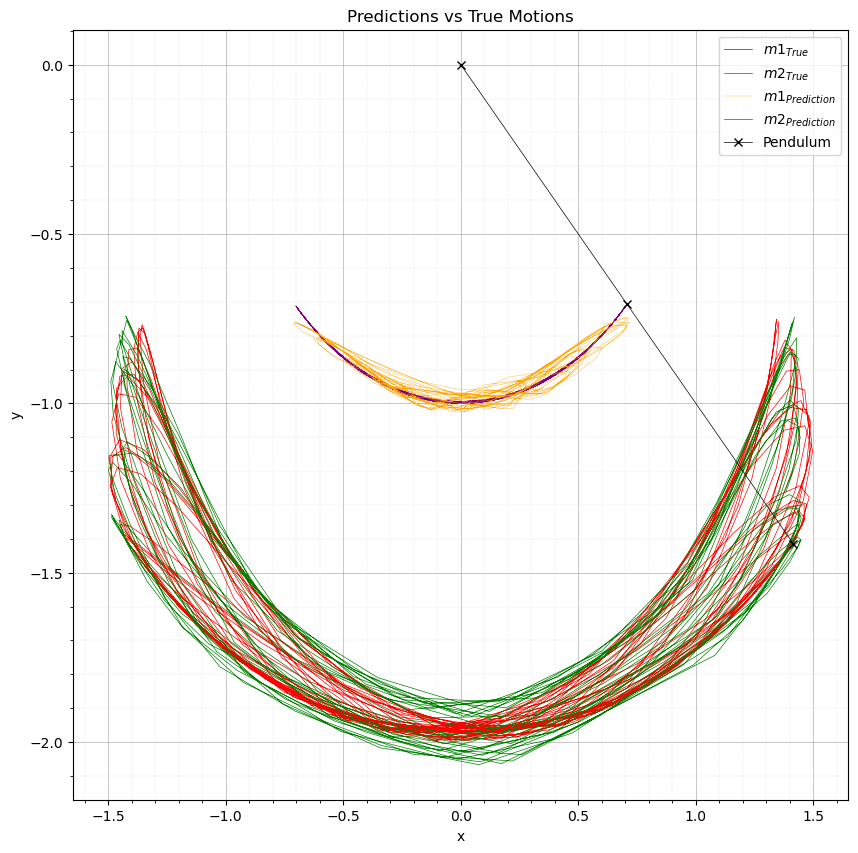

In [10]:
def predicted_plot(x1prediction, y1prediction, x2prediction, y2prediction, x1, x2, y1, y2): 
    """
    This function plots the values that we obtain from the train function defined above.
    
    Inputs:
        x1prediction: predicted value from train function
        x2prediction: ''                      ''
        y1prediction: ''                      ''
        y2prediction: ''                      ''
       
        x1: solutions from sols_normal function
        x2:''                      ''
        y1:''                      ''
        y2:''                      ''
        
    Outputs: graph of Predictions vs True Motions
    """
    
    
    # Formatting
    ax=plt.subplots(1, figsize=(10,10))
    
    # Plot of original model
    ax[1].plot(x1, y1, label="$m1_{True}$",c='purple', linewidth=0.5)
    ax[1].plot(x2, y2, label="$m2_{True}$",c='red', linewidth=0.5)
    
    # Plot of model prediction
    ax[1].plot(x1prediction, y1prediction, label=r"$m1_{Prediction}$",c ='orange', linewidth=0.25)
    ax[1].plot(x2prediction, y2prediction, label=r"$m2_{Prediction}$",c = 'green', linewidth=0.5)
    ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-x", label="Pendulum", color="black", linewidth=0.5)
    
    # More formatting with some personal preferences added
    ax[1].set_ylabel("y")
    ax[1].set_xlabel("x")
    plt.title("Predictions vs True Motions")
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.2')
    plt.legend()
    plt.show()
    
    return
    
# Making the plot run
predicted_plot(prediction[:,0],prediction[:,1],prediction[:,2],prediction[:,3],x1,x2,y1,y2)



### Graph Inferences
It is hard to see Mass m1's real motion as it is overlayed by Mass m1's predicted motion. However, model seems to prediciting motions well. 

## Task 2


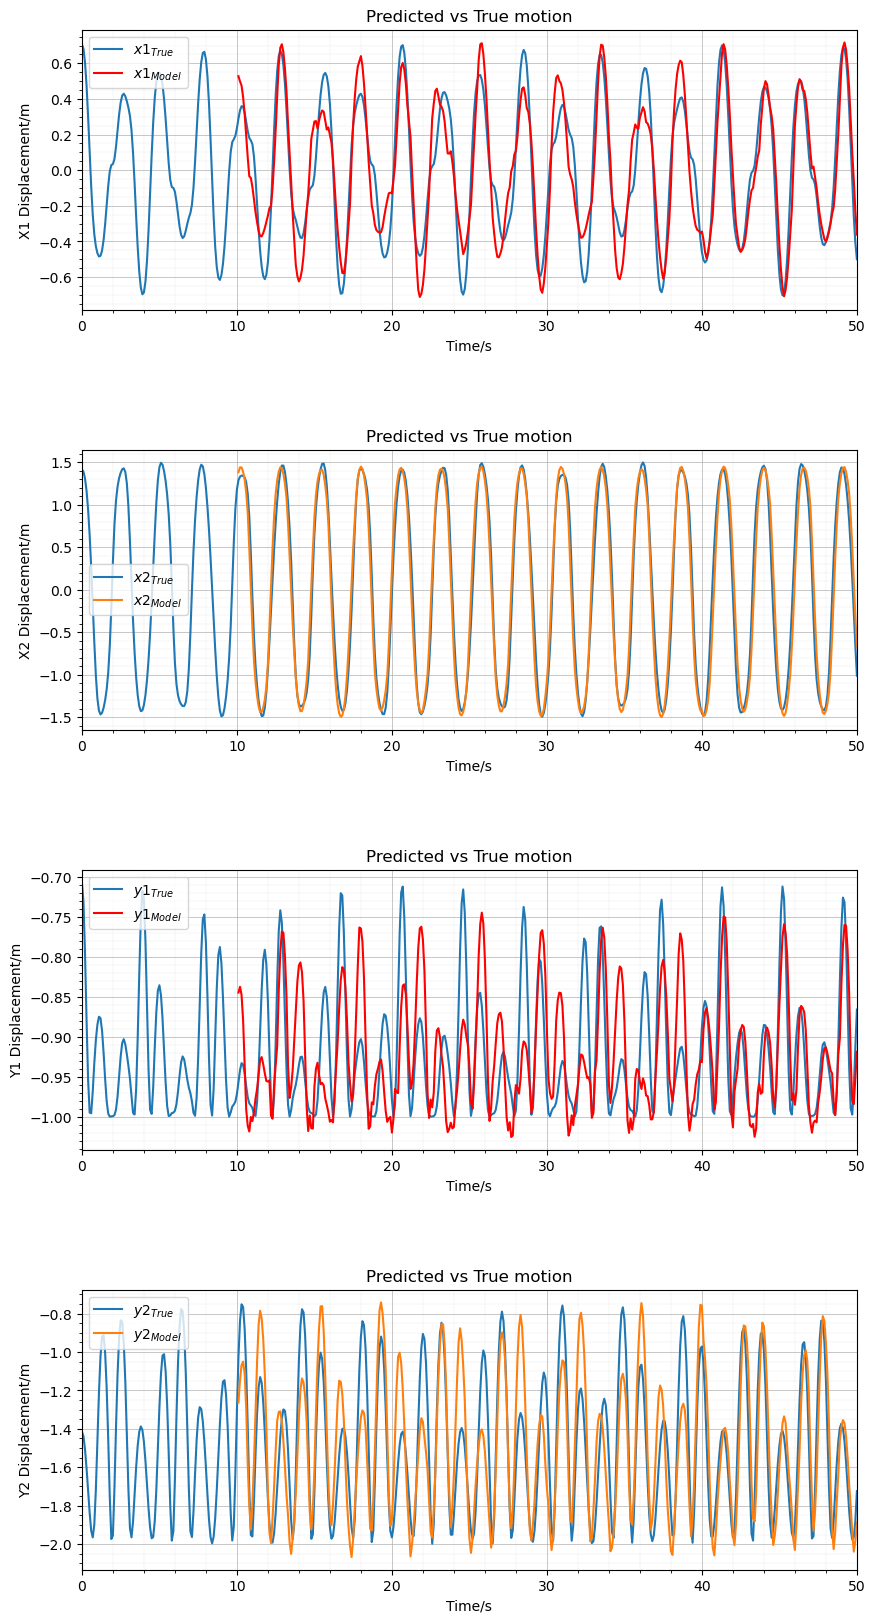

In [11]:
def compare_plot(predictions, true, t_arr, tlimit):
    """
    This function graphs a plot for comparison between the predicted vs true displacement both against time.

    Inputs:
        predictions: Predicted motion data.
        true: Actual motion data.
        t: Time array.
        tlimit: Time limit for the plot.
        
    
    Outputs: 4 graphs for comparison
    """
    # Formatting again
    fig, ax = plt.subplots(4, 1, figsize=(10, 20))
    plt.subplots_adjust(hspace=0.5)
    
    
    
    # First X-displacement plot
    ax[0].plot(t, true[0], label=r"$x1_{True}$")
    
    # its prediction plot
    ax[0].plot(t_arr[(len(t_arr) - len(predictions[:, 0])):], predictions[:, 0], label="$x1_{Model}$", color='red')
    ax[0].set_xlim(tlimit[0], tlimit[1])
    ax[0].set_xlabel('Time/s')
    ax[0].set_ylabel('X1 Displacement/m')
    ax[0].legend()
    ax[0].set_title('Predicted vs True motion')
    ax[0].grid(True, which='both', linestyle='-', linewidth=0.5)
    ax[0].minorticks_on()
    ax[0].grid(which='minor', linestyle=':', linewidth='0.2')
   
    
    # First Y-displacement plot
    ax[1].plot(t, true[1], label="$x2_{True}$")
    
    # its prediction again
    ax[1].plot(t_arr[(len(t_arr) - len(predictions[:, 2])):], predictions[:, 2], label=r"$x2_{Model}$")
    ax[1].set_xlim(tlimit[0], tlimit[1])  # limit
    ax[1].set_xlabel('Time/s')
    ax[1].set_ylabel('X2 Displacement/m')
    ax[1].legend()
    ax[1].set_title('Predicted vs True motion')
    ax[1].grid(True, which='both', linestyle='-', linewidth=0.5)
    ax[1].minorticks_on()
    ax[1].grid(which='minor', linestyle=':', linewidth='0.2')
    
    
    # Second X-displacement plot
    ax[2].plot(t_arr, true[2], label="$y1_{True}$")
    
    # same again
    ax[2].plot(t_arr[(len(t_arr) - len(predictions[:, 1])):], predictions[:, 1], label="$y1_{Model}$", color='red')
    ax[2].set_xlim(tlimit[0], tlimit[1])  # limit
    ax[2].set_xlabel('Time/s')
    ax[2].set_ylabel('Y1 Displacement/m')
    ax[2].legend()
    ax[2].set_title('Predicted vs True motion')
    ax[2].grid(True, which='both', linestyle='-', linewidth=0.5)
    ax[2].minorticks_on()
    ax[2].grid(which='minor', linestyle=':', linewidth='0.2')
    
    
    
    # Second Y-displacement plot
    ax[3].plot(t_arr, true[3], label="$y2_{True}$")
    
    # same again and again
    ax[3].plot(t_arr[(len(t_arr) - len(predictions[:, 0])):], predictions[:, 3], label="$y2_{Model}$")
    ax[3].set_xlim(tlimit[0], tlimit[1])
    ax[3].set_xlabel('Time/s')
    ax[3].set_ylabel('Y2 Displacement/m')
    ax[3].legend()
    ax[3].set_title('Predicted vs True motion')
    ax[3].grid(True, which='both', linestyle='-', linewidth=0.5)
    ax[3].minorticks_on()
    ax[3].grid(which='minor', linestyle=':', linewidth='0.2')
    
    
    return




# Parameters for comaprison as defined above 
x1, y1, x2, y2 = sols_normal(tmax, z0, t, L1,L2,m1,m2)
val=(x1,x2,y1,y2)
tmax2=(0,50)

# Running previosuly defined compare_plot function
compare_plot(prediction, val,t,tmax2)


## Graph Inferences:
From these graphs we can see the model is predicting the motion pretty well, especially for the X2 motion. Oevrall it seems as if the model is working well here.

## Task 3

In [12]:
# Defining the function we will use for Task 3
def model_diff_offset(z0, offsets, windowsize, model):
    """
    This function retrieves the model and trains it using the given offsets and then uses the '.evaluate' function to check the performance.

    Inputs:
        z0:         Pendulum angles
        offsets:    offsets to perform calculations on
        windowsize: each window size
        model:      specified model to train

    Returns:
        deviation: list of deviations 
    """

    # Solve the actual motion of the pendulum
    x1b, y1b, x2b, y2b = sols_normal(tmax, z0, t, L1, L2, m1, m2)

    # Separate data into test and train batches (70/30 split)
    high_b = int(0.7 * len(x1b))
    data_test_b = np.column_stack((x1b[high_b:-1], y1b[high_b:-1], x2b[high_b:-1], y2b[high_b:-1])).T
    data_train_b = np.column_stack((x1b[0:high_b], y1b[0:high_b], x2b[0:high_b], y2b[0:high_b])).T
    
    # Empty array to append deviations to
    deviation = []

    # Loop over all offsets
    for i in (range(len(offsets))):
        # Generate windows and labels for training and testing data
        train_input_b, train_label_b = window_from_data(data_train_b, offsets[i], windowsize)
        test_input_b, test_label_b = window_from_data(data_test_b, offsets[i], windowsize)
        
        # train the model with the current offset
        train(model, train_input_b, train_label_b, test_input_b, test_label_b, 1000)
        
        #reshape test input for evaluation
        reshape_test = test_input_b.reshape(test_input_b.shape[0], windowsize, test_input_b.shape[1])
        
        #Evaluate the model on the test data
        test_deviation = model.evaluate(reshape_test, test_label_b , verbose=1)
        
        # Append the deviation to the list
        deviation.append(test_deviation)
        
        
    return deviation

In [13]:
# Constructing offsets 
offset_2=np.arange(20,101,5)

# Utilising model_diff_offset
dev2= model_diff_offset(z0,offset_2,windowsize, model)


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.58it/s]


Training cost: 0.0015279798535630107
4/4 [==============================] - 0s 3ms/step - loss: 6.3097e-04


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.01it/s]


Training cost: 0.5486490726470947
3/3 [==============================] - 0s 2ms/step - loss: 9.7232e-04


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.92it/s]


Training cost: 0.5506342649459839
3/3 [==============================] - 0s 2ms/step - loss: 7.0096e-04


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.37it/s]


Training cost: 0.5450956225395203
3/3 [==============================] - 0s 3ms/step - loss: 7.9390e-04


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.05it/s]


Training cost: 0.5518384575843811
3/3 [==============================] - 0s 2ms/step - loss: 0.0015


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.55it/s]


Training cost: 0.5467027425765991
3/3 [==============================] - 0s 2ms/step - loss: 8.7789e-04


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.67it/s]


Training cost: 0.5467353463172913
3/3 [==============================] - 0s 2ms/step - loss: 0.0011


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.47it/s]


Training cost: 0.5500410795211792
3/3 [==============================] - 0s 2ms/step - loss: 9.6678e-04


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.81it/s]


Training cost: 0.5461514592170715
2/2 [==============================] - 0s 3ms/step - loss: 8.3456e-04


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.00it/s]


Training cost: 0.5534200668334961
2/2 [==============================] - 0s 3ms/step - loss: 0.0013


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 45.68it/s]


Training cost: 0.543441891670227
2/2 [==============================] - 0s 3ms/step - loss: 0.0013


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.95it/s]


Training cost: 0.5437628030776978
2/2 [==============================] - 0s 3ms/step - loss: 8.3793e-04


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.36it/s]


Training cost: 0.5536127686500549
2/2 [==============================] - 0s 3ms/step - loss: 0.0015


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.58it/s]


Training cost: 0.5421076416969299
2/2 [==============================] - 0s 3ms/step - loss: 8.1984e-04


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.47it/s]


Training cost: 0.5488042831420898
1/1 [==============================] - 0s 151ms/step - loss: 9.8194e-04


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.97it/s]


Training cost: 0.5485751032829285
1/1 [==============================] - 0s 146ms/step - loss: 0.0016


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.62it/s]


Training cost: 0.5519978404045105
1/1 [==============================] - 0s 149ms/step - loss: 8.4329e-04


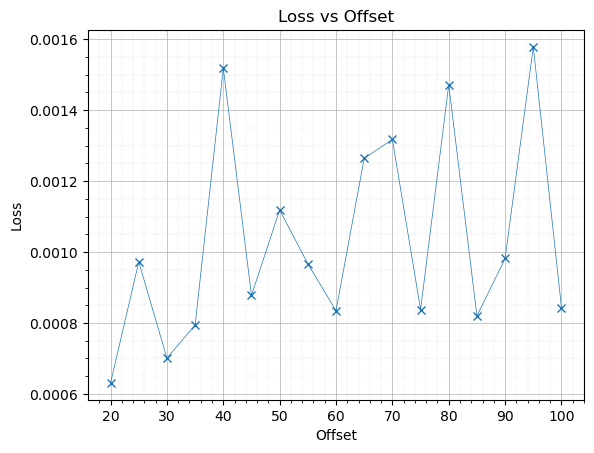

In [14]:
# Loss and offset plot
plt.figure()
plt.plot(np.arange(20,101,5), dev2, 'x-', linewidth=0.5)
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Loss vs Offset")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()

### Graph Inferences:
This graph changes each time we train it due to the random data nature of the pendulum but usually we see a spike somewhere in the data this may be due to overfitting. We also note that the test loss is in general below 0.0015 which is good. 

## Task 4


100%|███████████████████████████████████████| 20/20 [00:00<00:00, 514638.53it/s]


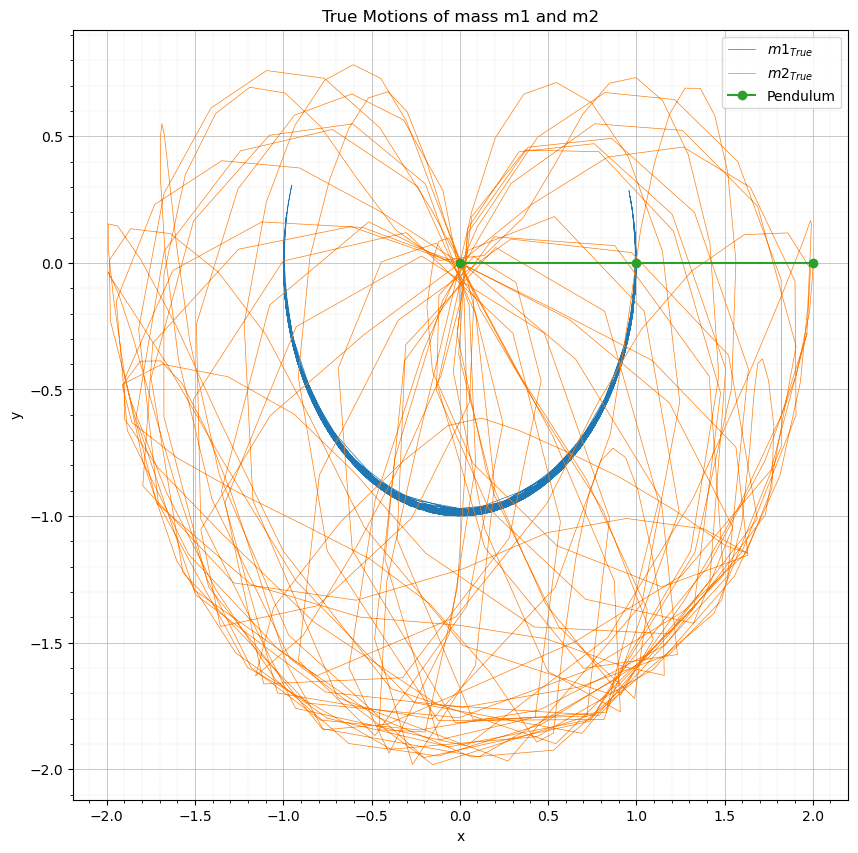

In [15]:
#updated initial paramters

#starting angles
z1=[np.pi/2,0,np.pi/2,0]

#lengths, masses and gravity constant
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81    

#time data
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Getting solutions with update parameters using previously defined 'sols_normal' fucntion. 
x1_4, y1_4, x2_4, y2_4 = sols_normal(tmax, z1, t, L1,L2,m1,m2)


# Plotting true pendulum positions
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(x1_4, y1_4,"-", label="$m1_{True}$", linewidth=0.5)
ax.plot(x2_4, y2_4,"-", label="$m2_{True}$", linewidth=0.5)
ax.plot([0, x1_4[0], x2_4[0]], [0, y1_4[0], y2_4[0]], "-o", label="Pendulum")
plt.ylabel("y")
plt.xlabel("x")
plt.title("True Motions of mass m1 and m2")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
ax.legend()



# New model for Task 4

model2=keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model2.compile(loss='mse', optimizer='adam')



# New train/test split again for new model
high_4 = int(0.7*len(y1_4))

#make array for training and testing with a 70/30 split
data_test2=np.column_stack((x1_4[high_4:-1], y1_4[high_4:-1],x2_4[high_4:-1], y2_4[high_4:-1])).T
data_train2=np.column_stack((x1_4[0:high_4], y1_4[0:high_4], x2_4[0:high_4], y2_4[0:high_4])).T


#initial parameters
steps=1000
windowsize=30
offset=100


#Get data training and testiong data sets 
train_data2, train_lb2 = window_from_data(data_train2,offset,windowsize)
test_data2, test_lb2 = window_from_data(data_test2,offset,windowsize)

100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.34it/s]


Training cost: 0.7597966194152832
1/1 [==============================] - 0s 10ms/step


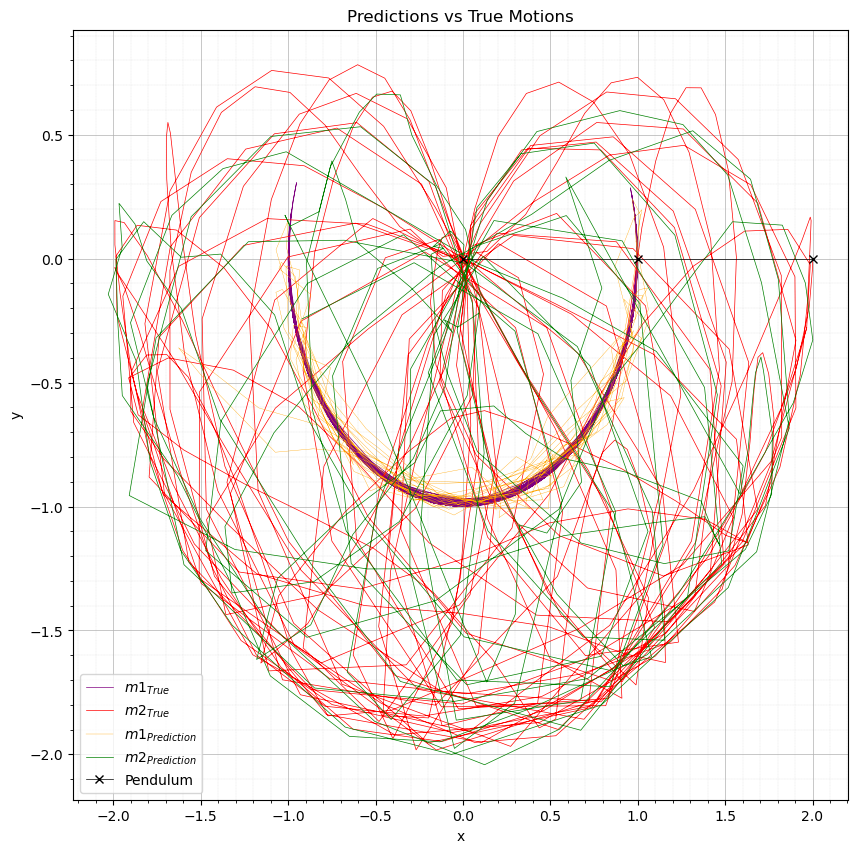

In [16]:
# Training new model using model 2 and previously defined "train" function. 
train(model2, train_data2, train_lb2, test_data2, test_lb2, steps)

# Reshaping again
input_train2 = train_data2.reshape(train_data2.shape[0], windowsize, train_data2.shape[1])
input_test2 = test_data2.reshape(test_data2.shape[0], windowsize, test_data2.shape[1])

# Predictions using trained model
prediction_train2 = model2.predict(input_train2)
prediction_test2 = model2.predict(input_test2)

# Joining arrays using numpys concatenate function like above
prediction_4 = np.concatenate((prediction_train2, prediction_test2), axis=0)


# Now, plotting the predicted motions and true motions using updated intial conditions
predicted_plot(prediction_4[:,0],prediction_4[:,1],prediction_4[:,2],prediction_4[:,3],x1_4,x2_4,y1_4, y2_4)

## Graph Inferences:
As the script depicted, this has shown a much more complex path and a lot more chaos. We also have a very low training cost. Very nice.  

In [ ]:
# Task 3 within Task 4

# Time
tmax2=(0,50)

# True motion
val_4 = (x1_4,x2_4,y1_4,y2_4)

#Plot x and y over time Original vs Predicted
compare_plot(prediction_4, val_4,t,tmax2)



#loss vs offset
offset_2=np.arange(20,101,5)

# Loss from training over offsets
dev3=model_diff_offset(z1,offset_2,windowsize,model2)


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.36it/s]


Training cost: 1.300054907798767
4/4 [==============================] - 0s 2ms/step - loss: 0.8170


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.35it/s]


Training cost: 1.1280529499053955
3/3 [==============================] - 0s 2ms/step - loss: 1.1015


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.77it/s]


Training cost: 1.1450507640838623
3/3 [==============================] - 0s 3ms/step - loss: 0.9812


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.76it/s]


Training cost: 1.1397881507873535
3/3 [==============================] - 0s 2ms/step - loss: 1.0012


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.00it/s]


Training cost: 1.1503795385360718
3/3 [==============================] - 0s 2ms/step - loss: 1.5679


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.98it/s]


Training cost: 1.1658775806427002
3/3 [==============================] - 0s 2ms/step - loss: 1.6601


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.49it/s]


Training cost: 1.156974196434021
3/3 [==============================] - 0s 2ms/step - loss: 2.2261


  8%|███▎                                     | 80/1000 [00:02<00:23, 38.54it/s]

In [ ]:
# Plot of Displacement Deviation vs Offset
plt.figure()
plt.plot(np.arange(20,101,5), dev3, '.-')
plt.xlabel("Offset")
plt.ylabel("Displacement Deviation")
plt.title("Displacement Deviation vs Offset")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()

# Task 5

In [ ]:
# Intials
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     

z0=[np.pi/4,0,np.pi/4,0]
z1=[np.pi/2,0,np.pi/2,0]

tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

steps=1000
windowsize=30
offset=20

# For z0
x13, y13, x23, y23 = sols_normal(tmax, z0, t, L1,L2,m1,m2)


# NEw modeel making sure 

model3=keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model3.compile(loss='mean_squared_error', optimizer='adam')



#splitting data train/test 70/30
high_5 = int(0.7*len(y1))

# NOT training on m1 but on m2
data_test3=np.column_stack((x13[high_5:-1], y13[high_5:-1],x23[high_5:-1], y23[high_5:-1])).T
data_train3=np.column_stack((x23[0:high_5], y23[0:high_5],np.zeros(len(y13[0:high_5])), np.zeros(len(y13[0:high_5])))).T





#Get data training and testing data sets 
train_data3, train_lb3 = window_from_data(data_train3,offset,windowsize)
test_data3, test_lb3 = window_from_data(data_test3,offset,windowsize)





train(model3, train_data3, train_lb3, test_data3, test_lb3, steps)

input_train3 = train_data3.reshape(train_data3.shape[0], windowsize, train_data3.shape[1])
input_test3 = test_data3.reshape(test_data3.shape[0], windowsize, test_data3.shape[1])

prediction_train3 = model3.predict(input_train3)
prediction_test3 = model3.predict(input_test3)

prediction_3 = np.concatenate((prediction_train3, prediction_test3), axis=0)




predicted_plot(prediction_3[:,0],prediction_3[:,1],prediction_3[:,2],prediction_3[:,3],x13,x23,y13, y23)


tmax2=(0,50)

val3 = (x13,x23,y13,y23)

#Plot x and y over time Original vs Predicted
compare_plot(prediction_3, val3,t,tmax2)



offset_3=np.arange(20,101,5)
#Get loss of training over the different offsets
dev4= model_diff_offset(z0,offset_2,windowsize, model3)

#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), dev4, '.-')
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Loss against Offset")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()

In [ ]:
# Intials
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     

z1=[np.pi/2,0,np.pi/2,0]

tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

steps=1000
windowsize=30
offset=20

# for z1
x13aa, y13aa, x23aa, y23aa = sols_normal(tmax, z1, t, L1,L2,m1,m2)


# NEw modeel making sure 

model3=keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(132, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model3.compile(loss='mean_squared_error', optimizer='adam')



#splitting data train/test 70/30
high_5 = int(0.7*len(y1))

# NOT training on m1 but on m2
data_test3aa=np.column_stack((x13aa[high_5:-1], y13aa[high_5:-1],x23aa[high_5:-1], y23aa[high_5:-1])).T
data_train3aa=np.column_stack((x23aa[0:high_5], y23aa[0:high_5],np.zeros(len(y13aa[0:high_5])), np.zeros(len(y13aa[0:high_5])))).T





#Get data training and testing data sets 
train_data3aa, train_lb3aa = window_from_data(data_train3aa,offset,windowsize)
test_data3aa, test_lb3aa = window_from_data(data_test3aa,offset,windowsize)





train(model3, train_data3aa, train_lb3aa, test_data3aa, test_lb3aa, steps)

input_train3 = train_data3aa.reshape(train_data3aa.shape[0], windowsize, train_data3aa.shape[1])
input_test3 = test_data3aa.reshape(test_data3aa.shape[0], windowsize, test_data3aa.shape[1])

prediction_train3aa = model3.predict(input_train3aa)
prediction_test3aa = model3.predict(input_test3aa)

prediction_3aa = np.concatenate((prediction_train3aa, prediction_test3aa), axis=0)




predicted_plot(prediction_3aa[:,0],prediction_3aa[:,1],prediction_3aa[:,2],prediction_3aa[:,3],x13aa,x23aa,y13aa, y23aa)


tmax2=(0,50)

val3aa = (x13aa,x23aa,y13aa,y23aa)

#Plot x and y over time Original vs Predicted
compare_plot(prediction_3aa, val3aa,t,tmax2)



offset_3=np.arange(20,101,5)
#Get loss of training over the different offsets
dev4= model_diff_offset(z1,offset_2,windowsize, model3)

#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), dev4, '.-')
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Loss against Offset")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()

## Graph Inferences:
From this graph we can conclude that the model can still predict to an acceptable degree of accuracy as the loss is fairly low, mostly below 0.002. However, there is a sporadic nature in the loss whereby it peaks up sometimes.

The first graph is for $pi/4$ and then the second graph is for $pi/2$ and shows the different nature between the two. 

# Workbook Conclusion:
This workbook goes into detail training a model on two masses on a double pendulum. The model seems to predict the $pi/4$ sitaution well however for the $pi/2$ it isn't as good as predicting this. This is most likely due to the hieghtened chaotic nature of the $pi/2$ situation. If we increase the amount of timesteps (i.e. make them smaller) however, we can decrease the chaotic nature as the system can learn better and therefore make improved predictions. 

## References
[1] Gholamy, Afshin; Kreinovich, Vladik; and Kosheleva, Olga, "Why 70/30 or 80/20 Relation Between Training
and Testing Sets: A Pedagogical Explanation" (2018). Departmental T echnical Reports (CS) . 1209.
https://scholarworks.utep.edu/cs_techrep/1209